## Import related API

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential, layers, backend
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, LeakyReLU, GRU, BatchNormalization
from keras.layers.core import RepeatVector
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error
from itertools import product

%matplotlib inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Control the upper limit of GPU memory

In [4]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

### Read the data

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

def read(path):
    return pd.read_csv(path)

In [6]:
path = "WeeklyFinalData.csv"
finalData = read(path)

In [7]:
train = finalData

In [8]:
date = train["Date"]
train.drop("Date",axis=1,inplace=True)

## Data preprocessing

### Add lag time as a predicted factor 
1. Add lag time from 1 to 4 for CCSP (Yangtze River nonferrous metals, China)
2. Split the data to Training set & Test set

In [9]:
def buildTrain(train, pastWeek=1, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    return np.array(X_train), np.array(Y_train)

### Min-max scaling 
The data is scaled to a fixed range [0,1]

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

### Add data to the specified time lag and normalize

In [12]:
def dataTimeLag(time_lag):

    print("Lag time = {}".format(time_lag))
    ## Time lag
    X1_train, Y1_train= buildTrain(train, pastWeek=time_lag, futureWeek=1)

    ## Split date to training & test data
    X1_training = pd.DataFrame(X1_train[0:int(X1_train.shape[0]*0.8)])
    X1_test = pd.DataFrame(X1_train[int(X1_train.shape[0]*0.8):])

    Y1_training = pd.DataFrame(Y1_train[0:int(Y1_train.shape[0]*0.8)])
    Y1_test = pd.DataFrame(Y1_train[int(Y1_train.shape[0]*0.8):])

    ## Normalize
    print("---Normalize---")
    X1_training_scaled = sc.fit_transform(X1_training)
    X1_test_scaled = sc.transform(X1_test)

    Y1_training_scaled = sc.fit_transform(Y1_training)
    Y1_test_scaled = sc.transform(Y1_test)

    ## Check the data dimension
    print("---Check the data dimension---")
    print("X1_training_scaled:{0}".format(X1_training_scaled.shape))
    print("Y1_training_scaled:{0}".format(Y1_training_scaled.shape))
    print("X1_test_scaled:{0}".format(X1_test_scaled.shape))
    print("Y1_test_scaled:{0}".format(Y1_test_scaled.shape))

    return [X1_training_scaled, Y1_training_scaled, X1_test_scaled, Y1_test_scaled]

## Building Model

### 2-layer Neural Network

In [13]:
def buildTwoLayerNN(training_data_shape, setting):

    keras.backend.clear_session()
    regressor = Sequential()
    L2 = tf.keras.regularizers.L2(setting[4])
    regressor.add(Dense(units=setting[1], activation =setting[0], input_dim=training_data_shape, kernel_initializer = setting[2], kernel_regularizer= L2))
    regressor.add(Dense(units=1)) 


    regressor.compile(optimizer=setting[3], loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return regressor

### Training the model

In [14]:
def training_model(data, setting, setting_name):

    ## data
    ### [X1_training_scaled, Y1_training_scaled, X1_test_scaled, Y1_test_scaled]

    ## Training model

    #training_data_shape, activation_function, hidden_node, initializer, optimizer
    input_sahpe = data[0].shape[1]
    regressor = buildTwoLayerNN(input_sahpe, setting[1:])
    history = regressor.fit(data[0], data[1], epochs= setting[0], verbose=0)


    RMSE = [i for i in history.history["root_mean_squared_error"]]
    score_data = pd.DataFrame({"Loss":history.history["loss"], "RMSE":RMSE})


    ##Test the predict value
    predict = regressor.predict(data[2])
  
    ##Using RMSE to evaluate the mdoel
    score = np.sqrt(mean_squared_error(predict, data[3]))

    ##Print out the result of all combinations
    performance = {
        "Epochs":setting_name[0],
        "Activation function":setting_name[1],
        "Hidden nodes":setting_name[2],
        "Initializer":setting_name[3],
        "Optimizer":setting_name[4],
        "Regularizer":setting_name[5],
        "In-sample RMSE": RMSE[-1],
        "Out-of-sample RMSE": score
    }
    

    ##Return the result
    predicts = pd.DataFrame(predict)
    return performance, predicts.stack().reset_index(drop=True)

### Control model Hyperparameter
such as:
* input factor dimension
* epoch
* activation_function
* hidden_node
* initializer
* optimizer

In [15]:
def main(input_data):

    ## data, epoch, activation_function, hidden_node, initializer, optimizer, L2 regularization
    ## epoches, activation_functions, hidden_nodes option
    epoches = [100, 200, 300]
    activation_functions = ["sigmoid", "tanh", "relu"]
    hidden_nodes = [5, 8, 11]


    ## initializer option
    small_random = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    Xavier = tf.keras.initializers.GlorotNormal()
    initializers = [small_random, Xavier]
    initializers_name = ["small_random", "Xavier"]

    # optimizer & learning rate decay option
    learning_rate_fn = tf.keras.optimizers.schedules.CosineDecay(
      initial_learning_rate = 0.01, 
      decay_steps = 10
    )

    # SGD with Cosine Learning rate decay
    SGD_cosine = tf.keras.optimizers.SGD(
      learning_rate=learning_rate_fn,
      name = "SGD_with_cosine"
    )

    # Adam with Cosine Learning rate decay
    Adam_cosine = tf.keras.optimizers.Adam(
      learning_rate=learning_rate_fn,
      name = "Adam_with_cosine"
    )

   # Momentum
    Momentum = tf.keras.optimizers.SGD(
      learning_rate=0.01,
      momentum=0.9,
      name = "Momentum"
    )

    # Momentum with Cosine Learning rate decay
    Mom_cosine = tf.keras.optimizers.SGD(
      learning_rate=learning_rate_fn,
      momentum=0.9,
      name = "Momentum_with_cosine"
    )

    ## regulariztion term (lamda)
    regularizer= [0, 0.001, 0.0001]
    
    ## optimizers option
    optimizers = ["SGD", SGD_cosine, "Adam", Adam_cosine, Momentum, Mom_cosine]
    optimizers_name = ["SGD", "SGD_with_cosine", "Adam", "Adam_with_cosine", "Momentum", "Momentum_with_cosine"]


    ## a combination of hyperparameters for 2 layer neural network
    sets = list(product(epoches, activation_functions, hidden_nodes, initializers, optimizers, regularizer))
    sets_name = list(product(epoches, activation_functions, hidden_nodes, initializers_name, optimizers_name, regularizer))

    ## create a dataframe to store the resulr, e.g., RMSE_scores, and predicted value
    data = input_data
    RMSE_scores = pd.DataFrame(columns = ["Epochs", "Activation function", "Hidden nodes", "Optimizer", "Initializer","Regularizer","In-sample RMSE","Out-of-sample RMSE"])
    predicts = pd.DataFrame(columns = list(range(94)))
    
    ## call the corresponding method to train the model and store the result of RMSE_scores, and predicted value
    for i in range(len(sets)):
        
        performance, predict = training_model(data, sets[i], sets_name[i])
        
        RMSE_scores = RMSE_scores.append(performance, ignore_index=True)
        predicts = predicts.append(predict, ignore_index=True)

    return RMSE_scores, predicts

In [14]:
## call the corresponding method to get the result
if __name__ == "__main__":
    data = dataTimeLag(4)
    RMSE_scores, predicts = main(data)

Lag time = 4
---Normalize---
---Check the data dimension---
X1_training_scaled:(380, 18)
Y1_training_scaled:(380, 1)
X1_test_scaled:(95, 18)
Y1_test_scaled:(95, 1)


### The best top five models based on in-sample forecasting result

In [15]:
RMSE_scores.sort_values("In-sample RMSE", inplace=True)
RMSE_scores.head(5)

,Epochs,Activation function,Hidden nodes,Optimizer,Initializer,Regularizer,In-sample RMSE,Out-of-sample RMSE
852,300,tanh,11,Adam,Xavier,0,0.039193,0.089589
960,300,relu,11,Adam,Xavier,0,0.039725,0.146489
925,300,relu,8,Adam,Xavier,0.001,0.039849,0.079309
926,300,relu,8,Adam,Xavier,0.0001,0.040007,0.067949
924,300,relu,8,Adam,Xavier,0,0.040484,0.079757


### Ensemble the top 5 models

RMSE of ensembling the top 5 models: 0.08561


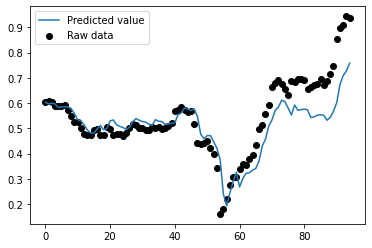

In [16]:
top_five_model = predicts.iloc[list(RMSE_scores.head(5).index),:]
ensemble_predict = top_five_model.apply(lambda x: x.mean())
ensemble_RMSE = np.sqrt(mean_squared_error(ensemble_predict, data[3]))
print("RMSE of ensembling the top 5 models: %.5f" %ensemble_RMSE)

plt.scatter(range(data[3].shape[0]), data[3], color='black', label = 'Raw data')
plt.plot(ensemble_predict, label = 'Predicted value')
plt.legend()

### Save all the results of model configuration in in-sample data as Settings_RMSE_scores.csv

In [17]:
RMSE_scores.reset_index(inplace=True, drop=True)
RMSE_scores.to_csv("Settings_RMSE_scores.csv", index=False)
RMSE_scores

,Epochs,Activation function,Hidden nodes,Optimizer,Initializer,Regularizer,In-sample RMSE,Out-of-sample RMSE
0,300,tanh,11,Adam,Xavier,0,0.039193,0.089589
1,300,relu,11,Adam,Xavier,0,0.039725,0.146489
2,300,relu,8,Adam,Xavier,0.001,0.039849,0.079309
3,300,relu,8,Adam,Xavier,0.0001,0.040007,0.067949
4,300,relu,8,Adam,Xavier,0,0.040484,0.079757
...,...,...,...,...,...,...,...,...
967,200,relu,5,Momentum_with_cosine,small_random,0.001,3.919460,5.222644
968,200,relu,11,Adam_with_cosine,small_random,0.001,4.207827,4.849051
969,100,relu,8,SGD_with_cosine,small_random,0.0001,5.463849,5.311232
970,300,relu,5,Momentum_with_cosine,small_random,0.0001,5.622427,5.592003


### The best configuration in out-of-sample data

In [18]:
RMSE_scores.sort_values("Out-of-sample RMSE", inplace=True)
RMSE_scores.reset_index(inplace=True, drop=True)
RMSE_scores[RMSE_scores["Out-of-sample RMSE"]==min(RMSE_scores["Out-of-sample RMSE"])]

,Epochs,Activation function,Hidden nodes,Optimizer,Initializer,Regularizer,In-sample RMSE,Out-of-sample RMSE
0,300,tanh,5,Momentum,Xavier,0,0.043948,0.047502
